In [5]:
!pip install textblob
import pandas as pd
import seaborn as sns
import numpy, textblob, string
from sklearn import decomposition, ensemble
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

ERROR: jsonschema 4.13.0 requires pkgutil-resolve-name>=1.3.10; python_version < "3.9", which is not installed.


In [6]:
# Reading data
trainDF = pd.read_json('CrackingArena/crackingarena_pruned.json')

In [7]:
trainDF.head()

,text,label,authors
0,You do not have sufficient rights to see the h...,Relevant,kill3r_cool
1,thnxx xD lolzz,Irrelavent,lolzz
2,Hello to all members we are going to start new...,Relevant,kill3r_cool
3,Thanks for this,Irrelavent,audi
4,SQL Injection Tutorial What is an SQL Injectio...,Relevant,unrated


In [9]:
# Label Data Visualization
sns.set_style('darkgrid') 
sns_count_plot = sns.countplot(trainDF['label'])
fig = sns_count_plot.get_figure()
fig.savefig("label_cmp.png")

ValueError: could not convert string to float: 'Relevant'

In [10]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'], test_size = 0.3)
valid_x, test_x, valid_y, test_y = model_selection.train_test_split(trainDF['text'], trainDF['label'], test_size = 0.5)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
test_y = encoder.fit_transform(test_y)

In [11]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(trainDF['text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [12]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(trainDF['text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(trainDF['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(trainDF['text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

C:\Users\bhave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:554: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [13]:
# Transoforming data
xtest_tfidf = tfidf_vect.transform(test_x)
xtest_tfidf_ngram = tfidf_vect_ngram.transform(test_x)
display(xtest_tfidf.shape)

(22464, 5000)

In [14]:
# Training Function
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return classifier, metrics.accuracy_score(predictions, valid_y)

In [15]:
# Naive Bayes on Count Vectors
%time _, accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print ("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
%time model_naive_bayes, accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
%time _, accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("NB, N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
%time _, accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("NB, CharLevel Vectors: ", accuracy)

CPU times: total: 15.6 ms
Wall time: 22.2 ms
NB, Count Vectors:  0.9874015046966123
CPU times: total: 31.2 ms
Wall time: 18.5 ms
NB, WordLevel TF-IDF:  0.9883363753728354
CPU times: total: 15.6 ms
Wall time: 18.5 ms
NB, N-Gram Vectors:  0.9868672928816276
CPU times: total: 46.9 ms
Wall time: 41.2 ms
NB, CharLevel Vectors:  0.9803677157993145


In [16]:
# Linear Classifier on Count Vectors
%time _, accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print ("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
%time model_logistic_regression, accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
%time _, accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
%time _, accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("LR, CharLevel Vectors: ", accuracy)

C:\Users\bhave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: total: 3.06 s
Wall time: 2.94 s
LR, Count Vectors:  0.9972399056225794
CPU times: total: 297 ms
Wall time: 298 ms
LR, WordLevel TF-IDF:  0.9916306815652406
CPU times: total: 234 ms
Wall time: 260 ms
LR, N-Gram Vectors:  0.9892712460490585
CPU times: total: 484 ms
Wall time: 485 ms
LR, CharLevel Vectors:  0.992209411031474


In [17]:
# SVM on Ngram Level TF IDF Vectors
%time model_svm, accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("SVM, N-Gram Vectors: ", accuracy)

CPU times: total: 20.2 s
Wall time: 20.9 s
SVM, N-Gram Vectors:  0.9946578818501536


In [18]:
# RF on Count Vectors
%time _, accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print ("RF, Count Vectors: ", accuracy)

# RF on Word Level TF IDF Vectors
%time model_random_forest, accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("RF, WordLevel TF-IDF: ", accuracy)

CPU times: total: 1min 31s
Wall time: 1min 32s
RF, Count Vectors:  0.9972399056225794
CPU times: total: 12.9 s
Wall time: 12.9 s
RF, WordLevel TF-IDF:  0.9974179762275742


In [19]:
ml_models = []
ml_accuracy_score = []
ml_f1_score = []
ml_recall_score = []
ml_precision_score = []

In [20]:
# ML models Prediction
def prediction(model, feature_vector_test, label):
    pred = model.predict(feature_vector_test)
    accuracy_score = metrics.accuracy_score(pred, label)
    f1_score = metrics.f1_score(pred, label)
    recall_score = metrics.recall_score(pred, label)
    precision_score = metrics.precision_score(pred, label)
    return accuracy_score, f1_score, recall_score, precision_score


# Naive Bayes Prediction
ml_models.append('Naive Bayes')
%time accuracy_score, f1_score, recall_score, precision_score = prediction(model_naive_bayes, xtest_tfidf, test_y)
ml_accuracy_score.append(accuracy_score)
ml_f1_score.append(f1_score)
ml_recall_score.append(recall_score)
ml_precision_score.append(precision_score)


# SVM Prediction
ml_models.append('SVM')
%time accuracy_score, f1_score, recall_score, precision_score = prediction(model_svm, xtest_tfidf_ngram, test_y)
ml_accuracy_score.append(accuracy_score)
ml_f1_score.append(f1_score)
ml_recall_score.append(recall_score)
ml_precision_score.append(precision_score)

# Logistic Regression Prediction
ml_models.append('Logistic Regression')
%time accuracy_score, f1_score, recall_score, precision_score = prediction(model_logistic_regression, xtest_tfidf, test_y)
ml_accuracy_score.append(accuracy_score)
ml_f1_score.append(f1_score)
ml_recall_score.append(recall_score)
ml_precision_score.append(precision_score)


# Random Forest Prediction
ml_models.append('Random Forest')
%time accuracy_score, f1_score, recall_score, precision_score = prediction(model_random_forest, xtest_tfidf, test_y)
ml_accuracy_score.append(accuracy_score)
ml_f1_score.append(f1_score)
ml_recall_score.append(recall_score)
ml_precision_score.append(precision_score)

CPU times: total: 31.2 ms
Wall time: 25.8 ms
CPU times: total: 3.34 s
Wall time: 3.35 s
CPU times: total: 31.2 ms
Wall time: 22 ms
CPU times: total: 562 ms
Wall time: 570 ms


In [21]:
# create a dataframe using ml models and accuracy, f1 score, recall and precision
ml_modelViz = pd.DataFrame()
ml_modelViz['models'] = ml_models
ml_modelViz['accuracy_score'] = ml_accuracy_score
ml_modelViz['f1_score'] = ml_f1_score
ml_modelViz['recall_score'] = ml_recall_score
ml_modelViz['precision_score'] = ml_precision_score

In [22]:
ml_modelViz

,models,accuracy_score,f1_score,recall_score,precision_score
0,Naive Bayes,0.989895,0.954862,0.968536,0.941569
1,SVM,0.994747,0.976428,0.995114,0.958431
2,Logistic Regression,0.991765,0.962664,0.991684,0.935294
3,Random Forest,0.997329,0.988114,0.998399,0.978039


C:\Users\bhave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


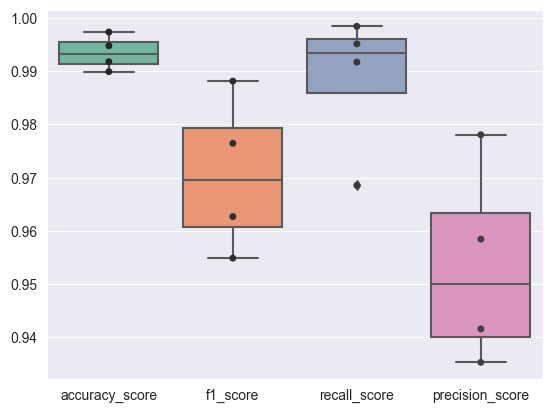

In [23]:
# ML models Scores Visualizations
sns_box_swarm_plot = sns.boxplot(data=ml_modelViz,  palette="Set2")
sns_box_swarm_plot = sns.swarmplot(data=ml_modelViz, color=".25")
fig = sns_box_swarm_plot.get_figure()
fig.savefig("ml_model_scores_cmp.png")

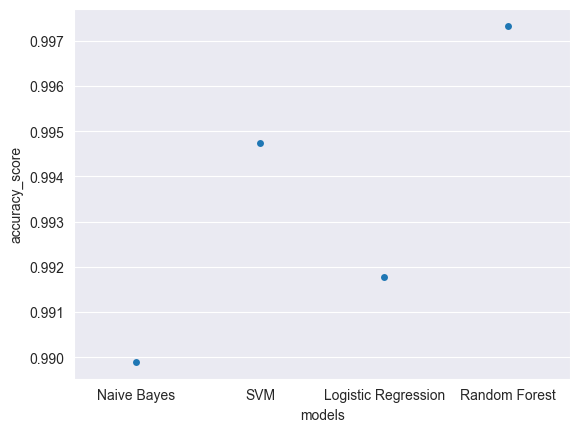

In [24]:
# ML models Accuracy Compare
sns_swarm_plot = sns.swarmplot(x='models', y='accuracy_score', data=ml_modelViz)
fig = sns_swarm_plot.get_figure()
fig.savefig("ml_model_accuracy_score_cmp.png")

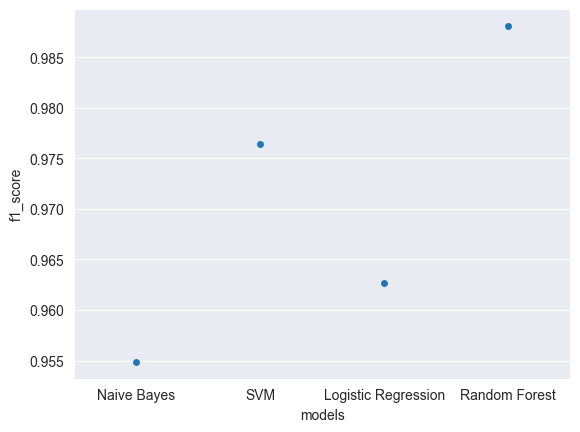

In [25]:
# ML models f1 score Compare
sns_swarmr_plot = sns.swarmplot(x='models', y='f1_score', data=ml_modelViz)
fig = sns_swarm_plot.get_figure()
fig.savefig("ml_model_f1_score_cmp.png")

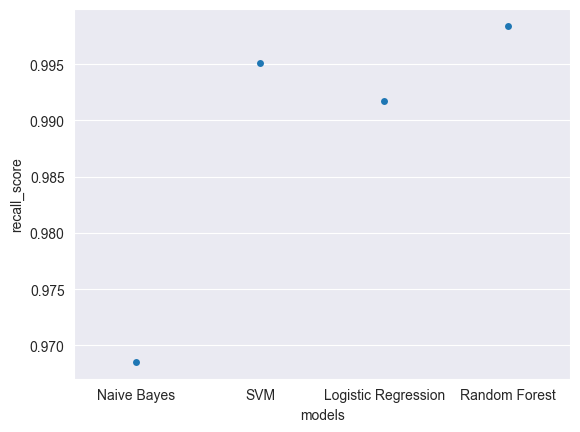

In [26]:
# ML models Recall Compare
sns_swarm_plot = sns.swarmplot(x='models', y='recall_score', data=ml_modelViz)
fig = sns_swarm_plot.get_figure()
fig.savefig("ml_model_recall_score_cmp.png")

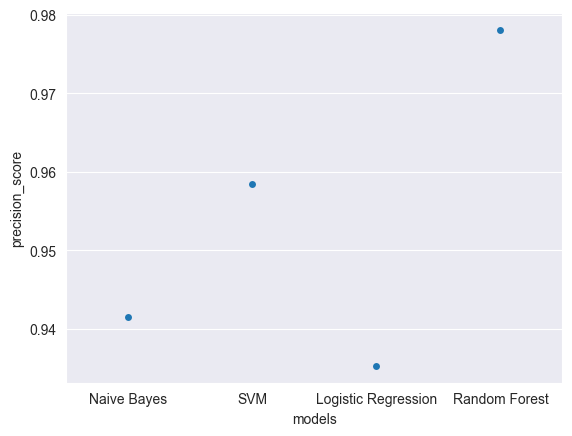

In [27]:
# ML models Precision Compare
sns_swarm_plot = sns.swarmplot(x='models', y='precision_score', data=ml_modelViz)
fig = sns_swarm_plot.get_figure()
fig.savefig("ml_model_precision_score_cmp.png")

In [29]:
from keras_preprocessing.sequence import pad_sequences
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('wiki-news-300d-1M.vec', encoding="utf8")):
    values = line.split()
    embeddings_index[values[0]] = numpy.asarray(values[1:], dtype='float32')

# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(trainDF['text'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
valid_seq_x = pad_sequences(token.texts_to_sequences(valid_x), maxlen=70)
test_seq_x = pad_sequences(token.texts_to_sequences(test_x), maxlen=70)

# create token-embedding mapping
embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [30]:
# Creating RNN LSTM Neural Network
def create_rnn_lstm():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.LSTM(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_lstm()
%time model_rnn_lstm, accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print ("RNN-LSTM, Word Embeddings",  accuracy)

702/702 [==============================] - 19s 26ms/step
CPU times: total: 6min 27s
Wall time: 1min 29s
RNN-LSTM, Word Embeddings 0.8888394248319459


In [31]:
# Creating RNN GRU Neural Network
def create_rnn_gru():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the GRU Layer
    lstm_layer = layers.GRU(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_gru()
%time model_rnn_gru, accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print ("RNN-GRU, Word Embeddings",  accuracy)

702/702 [==============================] - 17s 23ms/step
CPU times: total: 6min 31s
Wall time: 1min 25s
RNN-GRU, Word Embeddings 0.8888394248319459


In [32]:
dl_models = []
dl_accuracy_score = []
dl_f1_score = []
dl_recall_score = []
dl_precision_score = []

In [33]:
# RNN LSTM Prediction
%time pred = model_rnn_lstm.predict(test_seq_x)
rnn_lstm_pred = []
for i in pred:
    if i >= 0.5000009:
        rnn_lstm_pred.append(1)
    else:
        rnn_lstm_pred.append(0)
accuracy_score = metrics.accuracy_score(rnn_lstm_pred, test_y)
f1_score = metrics.f1_score(rnn_lstm_pred, test_y)
recall_score = metrics.recall_score(rnn_lstm_pred, test_y)
precision_score = metrics.precision_score(rnn_lstm_pred, test_y)
dl_models.append('RNN LSTM')
dl_accuracy_score.append(accuracy_score)
dl_f1_score.append(f1_score)
dl_recall_score.append(recall_score)
dl_precision_score.append(precision_score)

702/702 [==============================] - 15s 21ms/step
CPU times: total: 1min 1s
Wall time: 15.3 s


In [34]:
# RNN GRU Prediction
%time pred = model_rnn_gru.predict(test_seq_x)
rnn_gru_pred = []
for i in pred:
    if i >= 0.5000009:
        rnn_gru_pred.append(1)
    else:
        rnn_gru_pred.append(0)
score = metrics.accuracy_score(rnn_gru_pred, test_y)
f1_score = metrics.f1_score(rnn_gru_pred, test_y)
recall_score = metrics.recall_score(rnn_gru_pred, test_y)
precision_score = metrics.precision_score(rnn_gru_pred, test_y)
dl_models.append('RNN GRU')
dl_accuracy_score.append(accuracy_score)
dl_f1_score.append(f1_score)
dl_recall_score.append(recall_score)
dl_precision_score.append(precision_score)

702/702 [==============================] - 15s 21ms/step
CPU times: total: 1min 13s
Wall time: 15 s


In [35]:
# create a dataframe using dl models and accuracy, f1 score, recall and precision
dl_modelViz = pd.DataFrame()
dl_modelViz['models'] = dl_models
dl_modelViz['accuracy_score'] = dl_accuracy_score
dl_modelViz['f1_score'] = dl_f1_score
dl_modelViz['recall_score'] = dl_recall_score
dl_modelViz['precision_score'] = dl_precision_score

In [36]:
dl_modelViz

,models,accuracy_score,f1_score,recall_score,precision_score
0,RNN LSTM,0.98985,0.955711,0.946882,0.964706
1,RNN GRU,0.98985,0.961935,0.972735,0.951373


C:\Users\bhave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)


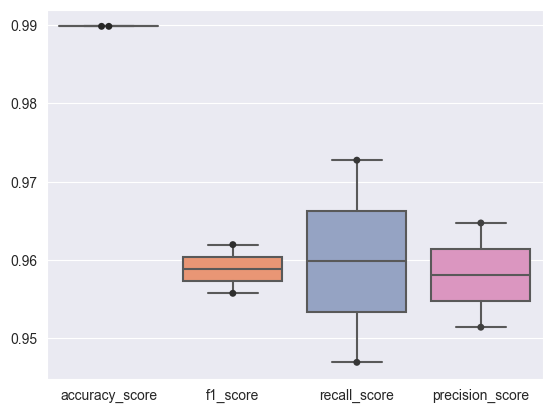

In [37]:
# DL models Scores Visualizations
sns_box_swarm_plot = sns.boxplot(data=dl_modelViz,  palette="Set2")
sns_box_swarm_plot = sns.swarmplot(data=dl_modelViz, color=".25")
fig = sns_box_swarm_plot.get_figure()
fig.savefig("dl_model_scores_cmp.png")

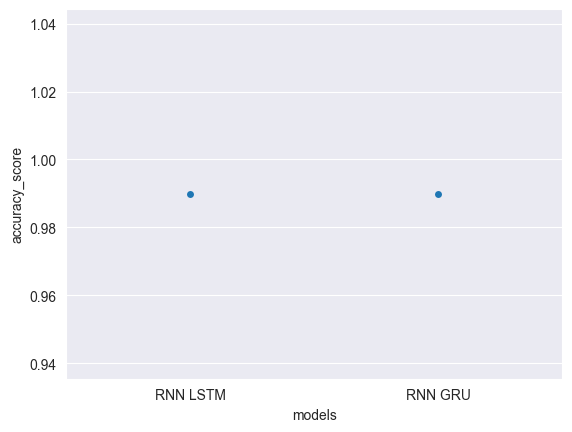

In [38]:
# DL models Accuracy Compare
sns_swarm_plot = sns.swarmplot(x='models', y='accuracy_score', data=dl_modelViz)
fig = sns_swarm_plot.get_figure()
fig.savefig('dl_model_accuracy_score_cmp.png')

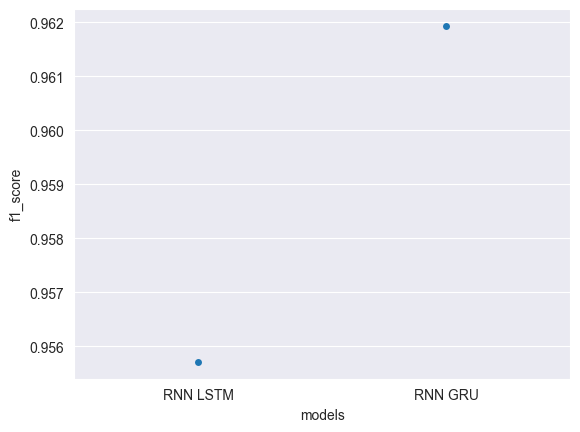

In [39]:
# DL models f1 score Compare
sns_swarm_plot = sns.swarmplot(x='models', y='f1_score', data=dl_modelViz)
fig = sns_swarm_plot.get_figure()
fig.savefig('dl_model_f1_score_cmp.png')

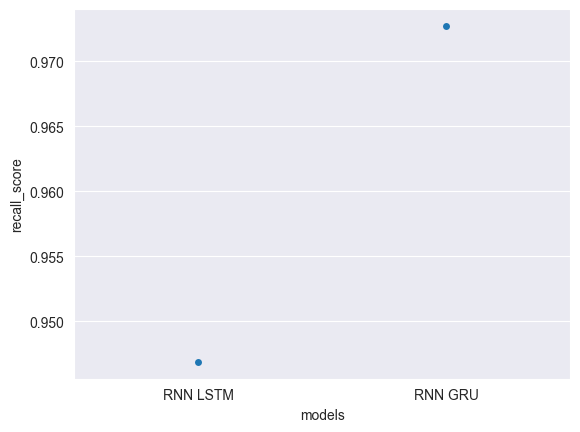

In [40]:
# DL models Recall Compare
sns_swarm_plot = sns.swarmplot(x='models', y='recall_score', data=dl_modelViz)
fig = sns_swarm_plot.get_figure()
fig.savefig('dl_model_recall_score_cmp.png')

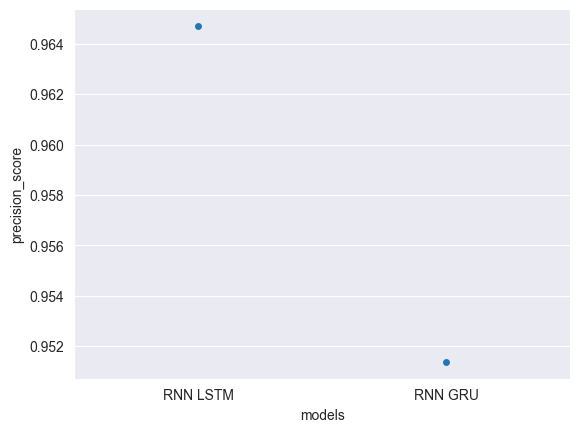

In [41]:
# DL models Precision Compare
sns_swarm_plot = sns.swarmplot(x='models', y='precision_score', data=dl_modelViz)
fig = sns_swarm_plot.get_figure()
fig.savefig('dl_model_precision_score_cmp.png')